<a href="https://colab.research.google.com/github/Rob685/coolstarsucsd/blob/master/DES_DERED_reading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reading the dereddened DES files. 
This notebook exists because we realized in 04/28/20 that we weren't using the dereddened magnitudes in DES, so the goal now is to rebuild the training set and reference sets with the dereddened columns.

On 06/02/2020 I'm reading the new DES data set that overlaps with the same spectral types as SMSS. That way we cover the same spectral types and don't need to have a hybrid training and reference set.

In [ ]:
import pandas as pd
import numpy as np
from scipy import stats
import scipy
import matplotlib.pyplot as plt
import matplotlib.ticker
from matplotlib.colors import LogNorm
from astropy.io import ascii
from astropy.table import Table
from astropy.io.misc.hdf5 import read_table_hdf5
from collections import Counter
from google.colab import drive
drive.mount('/content/gdrive')

import sys
sys.path.append('/content/gdrive/My Drive/Colab Notebooks')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
path_des = 'gdrive/My Drive/Colab Notebooks/des_workspace/'
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams['figure.facecolor'] = 'white'
plt.rc('text', usetex=True)
plt.rc('font', family='serif',size=15)
plt.rc('axes', linewidth=2.5) # change back to 1.5
plt.rc('axes', labelsize=15) # change back to 10
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)
plt.rc('legend', fontsize=15) # change back to 7

In [ ]:
! sudo apt-get install texlive-latex-recommended #1
#! sudo apt-get install dvipng texlive-fonts-recommended #2
! sudo apt-get install cm-super
! sudo apt-get install dvipng texlive-latex-extra texlive-fonts-recommended 
! wget http://mirrors.ctan.org/macros/latex/contrib/type1cm.zip #3
! unzip type1cm.zip -d /tmp/type1cm #4
! cd /tmp/type1cm/type1cm/ && sudo latex type1cm.ins  #5
! sudo mkdir /usr/share/texmf/tex/latex/type1cm #6
! sudo cp /tmp/type1cm/type1cm/type1cm.sty /usr/share/texmf/tex/latex/type1cm #7
! sudo texhash #8

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  fonts-droid-fallback fonts-lmodern fonts-noto-mono libcupsfilters1
  libcupsimage2 libgs9 libgs9-common libijs-0.35 libjbig2dec0 libkpathsea6
  libpotrace0 libptexenc1 libsynctex1 libtexlua52 libtexluajit2 libzzip-0-13
  lmodern poppler-data t1utils tex-common texlive-base texlive-binaries
  texlive-latex-base
Suggested packages:
  fonts-noto poppler-utils ghostscript fonts-japanese-mincho
  | fonts-ipafont-mincho fonts-japanese-gothic | fonts-ipafont-gothic
  fonts-arphic-ukai fonts-arphic-uming fonts-nanum debhelper gv
  | postscript-viewer perl-tk xpdf-reader | pdf-viewer texlive-latex-base-doc
  texlive-latex-recommended-doc texlive-pstricks
The following NEW packages will be installed:
  fonts-d

# Reading the queried data and applying completeness and color cuts

In [ ]:
des1 = pd.read_csv(path_des+'des_dered_data/Dered_dwarfs_000001.csv.gz',compression='gzip')
des1.shape

(13500000, 30)

In [ ]:
des1['MAG_AUTO_I'].max()

99.0

In [ ]:
des2 = pd.read_csv(path_des+'des_dered_data/Dered_dwarfs_000002.csv.gz',compression='gzip')
des2.shape

(13340786, 30)

In [ ]:
#des1_c1 = des1[(des1['MAG_AUTO_I'] <= 23.00) & (des1['MAG_AUTO_Z'] <= 22.25) & (des1['MAG_AUTO_Y'] <= 22.00)]
#print(des1_c1.shape)
#des1_c2 = des1_c1[(des1_c1['MAG_AUTO_I'] - des1_c1['MAG_AUTO_Z'] >= 1.0) & (des1_c1['MAG_AUTO_I'] - des1_c1['MAG_AUTO_Z'] <= 20) 
#  & (des1_c1['MAG_AUTO_Z'] - des1_c1['MAG_AUTO_Y'] >= 0.0)
#  ]
#print(des1_c2.shape)

(1857774, 30)
(882590, 30)


In [ ]:
# mag cuts done with regular mags, and color cuts made with dered mags. We'll train with dered mags
des1_c1 = des1[(des1['MAG_AUTO_I'] <= 23.00) & (des1['MAG_AUTO_Z'] <= 22.25) & (des1['MAG_AUTO_Y'] <= 22.00)]
print(des1_c1.shape)

des1_c2 = des1_c1[(des1_c1['MAG_AUTO_I_DERED'] - des1_c1['MAG_AUTO_Z_DERED'] >= 1.0) & (des1_c1['MAG_AUTO_I_DERED'] - des1_c1['MAG_AUTO_Z_DERED'] <= 20) 
  & (des1_c1['MAG_AUTO_Z_DERED'] - des1_c1['MAG_AUTO_Y_DERED'] >= 0.0)
  ]
print(des1_c2.shape)

(1857774, 30)
(823130, 30)


In [ ]:
des2_c1 = des2[(des2['MAG_AUTO_I'] <= 23.00) & (des2['MAG_AUTO_Z'] <= 22.25) & (des2['MAG_AUTO_Y'] <= 22.00)]
print(des2_c1.shape)
des2_c2 = des2_c1[(des2_c1['MAG_AUTO_I_DERED'] - des2_c1['MAG_AUTO_Z_DERED'] >= 1.0) & (des2_c1['MAG_AUTO_I_DERED'] - des2_c1['MAG_AUTO_Z_DERED'] <= 20) 
  & (des2_c1['MAG_AUTO_Z_DERED'] - des2_c1['MAG_AUTO_Y_DERED'] >= 0.0)
  ]
print(des2_c2.shape)

(1890295, 30)
(827386, 30)


In [ ]:
# putting it all together:
des_c2 = pd.concat([des1_c2,des2_c2])
des_c2.shape

In [ ]:
#des_c2.to_csv(path_des+'des_dered_data/des_c2.csv',index=False)
des_c2 = pd.read_csv(path_des+'des_dered_data/des_c2.csv')

# Reading data from Chris 06/02/2020

We need to build the SpT v. i - z relationship to know where to cut along i - z to match the spectral types of SMSS. Reading the new data and performing completeness and color parameter cuts here.

In [ ]:
des = pd.read_csv(path_des+'des_dered_data/DES_ROB_CUTS.csv',low_memory=False)
des.shape

(7741234, 33)

In [ ]:
imag = []
zmag = []
ymag = []
for i_mag,i_auto in des[['WAVG_MAG_PSF_I','MAG_AUTO_I']].values:
  if i_mag < 98:
    imag.append(i_mag)
  else:
    imag.append(i_auto)
for z_mag,z_auto in des[['WAVG_MAG_PSF_Z','MAG_AUTO_Z']].values:
  if z_mag < 98:
    zmag.append(z_mag)
  else:
    zmag.append(z_auto)
for y_mag,y_auto in des[['WAVG_MAG_PSF_Y','MAG_AUTO_Y']].values:
  if y_mag < 98:
    ymag.append(y_mag)
  else:
    ymag.append(y_auto)

In [ ]:
des['IMAG'] = imag
des['ZMAG'] = zmag
des['YMAG'] = ymag

In [ ]:
des_c1 = des[(des['IMAG'] <= 23.00) & (des['ZMAG'] <= 22.25) 
            & (des['YMAG'] <= 22.00)]
print(des_c1.shape)

# determined this cut based on spectral types to keep M6 and later. Used Rocio's matches and spectral types
des_c2 = des_c1[(des_c1['IMAG_DERED'] - des_c1['ZMAG_DERED'] >= 0.70) 
                & (des_c1['ZMAG_DERED'] - des_c1['YMAG_DERED'] >= 0.0)
  ]
print(des_c2.shape)

(6393806, 36)
(5401365, 36)


In [ ]:
#coords = np.array_split(des_c2[['COADD_OBJECT_ID','RA','DEC']],3)
#for idx,frame in enumerate(coords):
  #frame.to_csv(path_des+'des_dered_data/des_c2_rob_cuts_coords_{}.csv'.format(idx),index=False) # upload these to NOAO

In [ ]:
des_c2[['COADD_OBJECT_ID','RA','DEC']].to_csv(path_des+'des_dered_data/des_c2_rob_cuts_coords_all.csv',index=False)

In [ ]:
des_c2.to_csv(path_des+'des_dered_data/des_c2_rob_cuts.csv.gz',compression='gzip',index=False)

## Exploring the magnitude and color space of the dered data

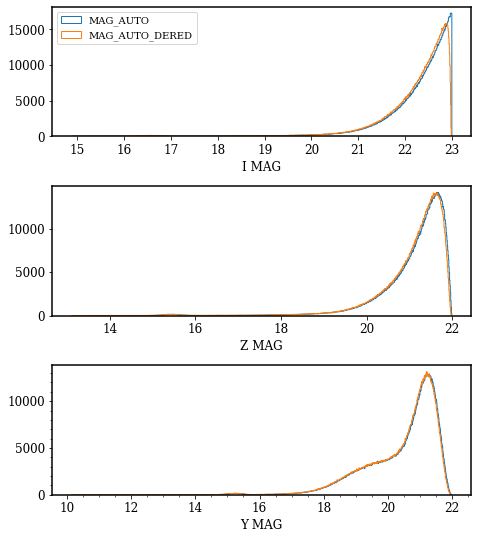

In [ ]:
fig = plt.figure(1, figsize=(2*3.4, 3*3.4*3/4.))
ax1=plt.subplot(311)
ax1.hist(des_c2['MAG_AUTO_I'],histtype='step',
         #density=True,
         bins=1000,label='MAG_AUTO')
ax1.hist(des_c2['MAG_AUTO_I_DERED'],histtype='step',
         #density=True,
         bins=1000,label='MAG_AUTO_DERED')
plt.legend(loc='upper left',prop={'size':10})
ax1.set_xlabel('I MAG')
#ax1.axvline(x=2.0,ls='--',color='r')

ax2=plt.subplot(312)
ax2.hist(des_c2['MAG_AUTO_Z'],histtype='step',
         #density=True,
         bins=1000,)
ax2.hist(des_c2['MAG_AUTO_Z_DERED'],histtype='step',
         #density=True,
         bins=1000)
#plt.legend(loc='upper left')
ax2.set_xlabel('Z MAG')
#ax1.axvline(x=2.0,ls='--',color='r')

ax3=plt.subplot(313)
ax3.hist(des_c2['MAG_AUTO_Y'],histtype='step',
         #density=True,
         bins=1000,)
ax3.hist(des_c2['MAG_AUTO_Y_DERED'],histtype='step',
         #density=True,
         bins=1000)
#plt.legend(loc='upper left')
ax3.set_xlabel('Y MAG')

plt.minorticks_on()
plt.tight_layout()

plt.show()

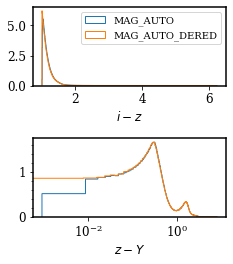

In [ ]:
fig = plt.figure(1, figsize=(3.4, 2*3.4*3/4.))
ax1=plt.subplot(311)
ax1.hist(des_c2['MAG_AUTO_I']-des_c2['MAG_AUTO_Z'],histtype='step',density=True,bins=1000,label='MAG_AUTO')
ax1.hist(des_c2['MAG_AUTO_I_DERED']-des_c2['MAG_AUTO_Z_DERED'],histtype='step',density=True,bins=1000,label='MAG_AUTO_DERED')
plt.legend(loc='upper right',prop={'size':10})
ax1.set_xlabel('$i - z$')
#ax1.axvline(x=2.0,ls='--',color='r')
#ax1.set_xscale('log')


ax2=plt.subplot(312)
ax2.hist(des_c2['MAG_AUTO_Z']-des_c2['MAG_AUTO_Y'],histtype='step',density=True,bins=1000)
ax2.hist(des_c2['MAG_AUTO_Z_DERED']-des_c2['MAG_AUTO_Y_DERED'],histtype='step',density=True,bins=1000)
#plt.legend(loc='upper left')
ax2.set_xlabel('$z - Y$')
#ax1.axvline(x=2.0,ls='--',color='r')
ax2.set_xscale('log')

plt.minorticks_on()
plt.tight_layout()

plt.show()

In [ ]:
mags_c2 = des_c2[['MAG_AUTO_I','MAG_AUTO_Z','MAG_AUTO_Y']].dropna(how='any')
print(mags_c2.shape)

(1650516, 3)


In [ ]:
mags_c2_dered = des_c2[['MAG_AUTO_I_DERED','MAG_AUTO_Z_DERED','MAG_AUTO_Y_DERED']].dropna(how='any')
print(mags_c2_dered.shape)

(1650516, 3)


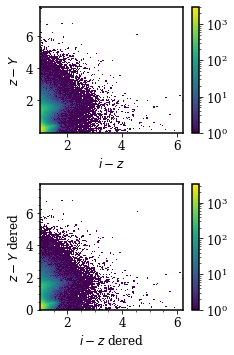

In [ ]:
fig = plt.figure(1, figsize=(1*3.4, 2*3.4*3/4.))
ax1 = plt.subplot(2,1,1)
plt.hist2d(mags_c2['MAG_AUTO_I']-mags_c2['MAG_AUTO_Z'],mags_c2['MAG_AUTO_Z']-mags_c2['MAG_AUTO_Y'],bins=500,norm=LogNorm())
plt.gca().set_xlabel('$i - z$')
plt.gca().set_ylabel('$z - Y$')
plt.colorbar()
#plt.show()

ax2 = plt.subplot(2,1,2)
plt.hist2d(mags_c2_dered['MAG_AUTO_I_DERED']-mags_c2_dered['MAG_AUTO_Z_DERED'],mags_c2_dered['MAG_AUTO_Z_DERED']-mags_c2_dered['MAG_AUTO_Y_DERED'],bins=500,norm=LogNorm())
plt.gca().set_xlabel('$i - z$ dered')
plt.gca().set_ylabel('$z - Y$ dered')
plt.colorbar()

plt.tight_layout()
plt.minorticks_on()
plt.show()

In [ ]:
i_diff = des_c2['MAG_AUTO_I'] - des_c2['MAG_AUTO_I_DERED']
z_diff = des_c2['MAG_AUTO_Z'] - des_c2['MAG_AUTO_Z_DERED']
Y_diff = des_c2['MAG_AUTO_Y'] - des_c2['MAG_AUTO_Y_DERED']

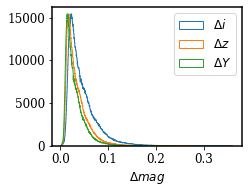

In [ ]:
fig = plt.figure(1, figsize=(1*3.4, 1*3.4*3/4.))
plt.hist(i_diff,histtype='step',bins=1000,label='$\Delta i$')
plt.hist(z_diff,histtype='step',bins=1000,label='$\Delta z$')
plt.hist(Y_diff,histtype='step',bins=1000,label='$\Delta Y$')
plt.xlabel('$\Delta mag$')
plt.legend()
plt.show()

In [ ]:
#des_c2[['COADD_OBJECT_ID','RA','DEC']].to_csv(path_des+'/des_dered_data/des_c2_dered_coords.csv',index=False)

# Reading Crossmatched Data

We only have 11,055 matches to 2MASS, so I'm avoiding that and only using gaia dr2 and AllWISE.

In [ ]:
# reading the base reference set:
des_c2 = pd.read_csv(path_des+'des_dered_data/des_c2_rob_cuts.csv.gz',compression='gzip')

In [ ]:
#des_c2[['COADD_OBJECT_ID','RA','DEC']].to_csv(path_des+'/des_dered_data/des_c2_dered_coords.csv',index=False)

In [ ]:
# gaia:
des_c2_gdr2_0 = pd.read_csv(path_des+'des_dered_data/des_c2_rob_gdr2_0.csv',low_memory=False)
des_c2_gdr2_1 = pd.read_csv(path_des+'des_dered_data/des_c2_rob_gdr2_1.csv',low_memory=False)
des_c2_gdr2_2 = pd.read_csv(path_des+'des_dered_data/des_c2_rob_gdr2_1.csv',low_memory=False)

des_c2_gdr2 = pd.concat([des_c2_gdr2_0,des_c2_gdr2_1,des_c2_gdr2_2])
print(des_c2_gdr2.shape)

# allwise:
des_c2_aw_0 = pd.read_csv(path_des+'des_dered_data/des_c2_rob_aw_0.csv',low_memory=False)
des_c2_aw_1 = pd.read_csv(path_des+'des_dered_data/des_c2_rob_aw_1.csv',low_memory=False)
des_c2_aw_2 = pd.read_csv(path_des+'des_dered_data/des_c2_rob_aw_1.csv',low_memory=False)

des_c2_aw = pd.concat([des_c2_aw_0,des_c2_aw_1,des_c2_aw_2])
print(des_c2_aw.shape)

(278124, 102)
(2000608, 104)


In [ ]:
# exploring dupes

des_g_nodupes = des_c2_gdr2.sort_values('dist_arcsec', ascending=True).drop_duplicates('t1_coadd_object_id')
print(des_g_nodupes.shape)

des_aw_nodupes = des_c2_aw.sort_values('dist_arcsec', ascending=True).drop_duplicates('t1_coadd_object_id')
print(des_aw_nodupes.shape)

(184778, 102)
(1347975, 104)


In [ ]:
# cleaning data first because merging directly with des_aw_nodupes crashes the RAM
data_clean1 = des_aw_nodupes[des_aw_nodupes['ph_qual'].str.startswith(('AA'),na=False)]
print(data_clean1.shape)
data_clean2 = data_clean1[data_clean1['ext_flg'] == 0.0]
print(data_clean2.shape)
data_clean3 = data_clean2[(data_clean2['cc_flags'].str.startswith(('00'),na=False)) & (data_clean2['w1snr'] > 10.0) 
                        & (data_clean2['w2snr'] > 10.0)
                          ]
print(data_clean3.shape)

(251841, 104)
(250933, 104)
(227257, 104)


In [ ]:
des_merged1 = des_c2.merge(des_g_nodupes,right_on='t1_coadd_object_id',left_on='COADD_OBJECT_ID',how='outer',suffixes=('','_y'))
des_merged1 = des_merged1.drop(des_merged1.filter(regex='_y').columns, axis=1)
des_merged1.shape

(5401365, 138)

In [ ]:
des_merged1.parallax.count()

136136

In [ ]:
# if it's not in AllWISE it won't be used in the training set or the reference set anyway, so merge as inner to avoid RAM crash
des_merged2 = des_merged1.merge(data_clean3,left_on='COADD_OBJECT_ID',right_on='t1_coadd_object_id',how='inner',suffixes=('','_y'))
des_merged2 = des_merged2.drop(des_merged2.filter(regex='_y').columns, axis=1)
des_merged2.shape

(227257, 228)

In [ ]:
# dropping any dupes:
des_merged3 = des_merged2.drop_duplicates(subset='COADD_OBJECT_ID')
des_merged3.to_csv(path_des+'/des_dered_data/des_merged_rob_cuts.csv.gz',compression='gzip',index=False)

In [ ]:
des_merged3.shape

(227257, 228)

# Beginning to cut for the Training Set

Start here if data is already cut and merged with Gaia DR 2 and AllWISE

In [ ]:
# new reference set:
des_merged3 = pd.read_csv(path_des+'/des_dered_data/des_merged_rob_cuts.csv.gz',compression='gzip',low_memory=False)

In [ ]:
# reading matches to Gaia DR2 distances
des_c2_dist = pd.read_csv(path_des+'/des_dered_data/des_c2_dered_distances.csv',low_memory=False)

In [ ]:
# distances:
des_merged4 = des_merged3.merge(des_c2_dist,on='COADD_OBJECT_ID',how='left',suffixes=('','_y'))
des_merged4 = des_merged4.drop(des_merged4.filter(regex='_y').columns, axis=1)
des_merged4.shape

(227257, 238)

In [ ]:
#des_merged4.to_csv(path_des+'/des_dered_data/des_merged_rob_cuts_distances.csv.gz',compression='gzip',index=False)

## Selecting Parallax

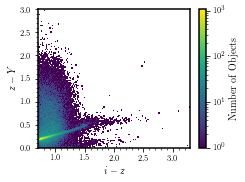

In [ ]:
fig = plt.figure(1, figsize=(1*3.4, 1*3.4*3/4.))
#ax1 = plt.subplot(2,1,1)
#plt.hist2d(des_merged3['WAVG_MAG_PSF_I_DERED']-des_merged3['WAVG_MAG_PSF_Z_DERED'],des_merged3['WAVG_MAG_PSF_Z_DERED']-des_merged3['WAVG_MAG_PSF_Y_DERED'],bins=500,norm=LogNorm()
#          ,rasterized=True
#           )
#plt.gca().set_xlabel('$i - z$')
#plt.gca().set_ylabel('$z - Y$')
#plt.colorbar()
#plt.minorticks_on()
#textstr = 'WAVG MAG PSF DERED'
#props = dict(boxstyle='round', facecolor='white', alpha=0.5)

# place a text box in upper left in axes coords
#ax1.text(0.05, 0.95, textstr, transform=ax1.transAxes, fontsize=12,
#        verticalalignment='top', bbox=props)

#ax2 = plt.subplot(2,1,1)
plt.hist2d(des_merged3['IMAG_DERED']-des_merged3['ZMAG_DERED'],des_merged3['ZMAG_DERED']-des_merged3['YMAG_DERED'],bins=500,norm=LogNorm()
          ,rasterized=True
           )
plt.gca().set_xlabel('$i - z$')
plt.gca().set_ylabel('$z - Y$')
plt.colorbar().set_label('Number of Objects')

#textstr = 'Corrected MAG\_DERED'
#props = dict(boxstyle='round', facecolor='white', alpha=0.5)

# place a text box in upper left in axes coords
#plt.text(0.05, 0.95, textstr, transform=ax2.transAxes, fontsize=12,
#        verticalalignment='top', bbox=props)
plt.ylim(0.0,3.0)
plt.minorticks_on()
plt.savefig('gdrive/My Drive/Colab Notebooks/figures/des_wavg_correction_hist2d.pdf',dpi=300,bbox_inches='tight',padding=0)
plt.show()

In [ ]:
des_merged3.shape

(227257, 228)

(73275, 238)


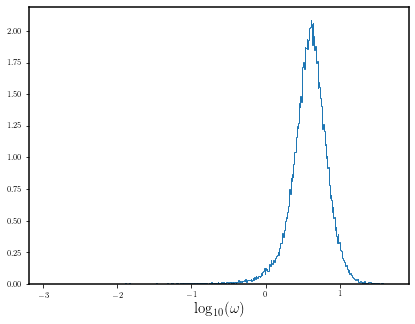

In [ ]:
# cutting along parallax:
pos_par = des_merged4[des_merged4['parallax'] > 0.0]
print(pos_par.shape)

fig = plt.figure(1, figsize=(2*3.4, 2*3.4*3/4.))
plt.hist(np.log10(pos_par['parallax']),bins=500,histtype='step',density=True)
#plt.hist(des_c4_g['log_par'],bins=1000,histtype='step',density=True)
plt.xlabel('$\log_{10}(\omega)$')
#plt.xscale('log')
plt.show()

## Checking Kiman overlap and Gagne overlap

In [ ]:
# investigating how many things we share with Rocio's dwarfs:
path_kiman = 'gdrive/My Drive/Colab Notebooks/kiman_etal_mdwarfs/'

In [ ]:
kiman = pd.read_csv(path_kiman+'kiman_etal_mdwarfs.csv')
kiman.shape

(74216, 95)

In [ ]:
kiman_goodastro = kiman[kiman['astro'] == 1]

In [ ]:
#kiman_goodastro[['RAdegG',
 #'DEdegG',]].to_csv(path_kiman+'kiman_etal_mdwarfs_goodastro_coords.csv',index=False)

In [ ]:
# kiman good astro matched with DES DR1 in NOAO
kiman_des = pd.read_csv(path_kiman+'kiman_goodastro_desdr1.csv')
kiman_des = kiman_des[kiman_des['dist_arcsec'] <= 0.5]
kiman_des.shape

(5314, 255)

In [ ]:
imag_dered = []
zmag_dered = []
ymag_dered = []
for i_mag,i_auto in kiman_des[['wavg_mag_psf_i_dered','mag_auto_i_dered']].values:
  if i_mag < 98:
    imag_dered.append(i_mag)
  else:
    imag_dered.append(i_auto)
for z_mag,z_auto in kiman_des[['wavg_mag_psf_z_dered','mag_auto_z_dered']].values:
  if z_mag < 98:
    zmag_dered.append(z_mag)
  else:
    zmag_dered.append(z_auto)
for y_mag,y_auto in kiman_des[['wavg_mag_psf_y_dered','mag_auto_y_dered']].values:
  if y_mag < 98:
    ymag_dered.append(y_mag)
  else:
    ymag_dered.append(y_auto)

kiman_des['IMAG_DERED'] = imag_dered
kiman_des['ZMAG_DERED'] = zmag_dered
kiman_des['YMAG_DERED'] = ymag_dered

In [ ]:
imag = []
zmag = []
ymag = []
for i_mag,i_auto in kiman_des[['wavg_mag_psf_i','mag_auto_i']].values:
  if i_mag < 98:
    imag.append(i_mag)
  else:
    imag.append(i_auto)
for z_mag,z_auto in kiman_des[['wavg_mag_psf_z','mag_auto_z']].values:
  if z_mag < 98:
    zmag.append(z_mag)
  else:
    zmag.append(z_auto)
for y_mag,y_auto in kiman_des[['wavg_mag_psf_y','mag_auto_y']].values:
  if y_mag < 98:
    ymag.append(y_mag)
  else:
    ymag.append(y_auto)

kiman_des['IMAG'] = imag
kiman_des['ZMAG'] = zmag
kiman_des['YMAG'] = ymag

In [ ]:
#kiman_des_sdsscols = kiman_goodastro.merge(kiman_des,right_on=['t1_radegg','t1_dedegg',],left_on=['RAdegG','DEdegG'],how='inner')
#kiman_des_sdsscols.shape

In [ ]:
# query cuts:
kiman_des_c0 = kiman_des[(kiman_des['imaflags_iso_i'] == 0) & (kiman_des['imaflags_iso_z'] == 0) & (kiman_des['flags_i'] < 4) & (kiman_des['flags_z'] < 4)]
print(kiman_des_c0.shape)
kiman_des_c02 = kiman_des_c0[(kiman_des['mag_auto_i'] - kiman_des['mag_auto_z'] >= 0.75) | (kiman_des['wavg_mag_psf_i'] - kiman_des['wavg_mag_psf_z'] >= 0.75)]
print(kiman_des_c02.shape)

(4264, 261)
(417, 261)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


In [ ]:
# mag cuts done with regular mags, and color cuts made with dered mags. We'll train with dered mags
kiman_des_c1 = kiman_des_c02[(kiman_des_c02['mag_auto_i'] <= 23.00) & (kiman_des_c02['mag_auto_z'] <= 22.25) & (kiman_des_c02['mag_auto_y'] <= 22.00)]
print(kiman_des_c1.shape)
kiman_des_c2 = kiman_des_c1[(kiman_des_c1['mag_auto_i_dered'] - kiman_des_c1['mag_auto_z_dered'] >= 0.7) & 
                            (kiman_des_c1['mag_auto_i_dered'] - kiman_des_c1['mag_auto_z_dered'] <= 20) 
  & (kiman_des_c1['mag_auto_z_dered'] - kiman_des_c1['mag_auto_y_dered'] >= 0.0)
  ]
print(kiman_des_c2.shape)

(417, 261)
(384, 261)


In [ ]:
kiman_des_c3 = kiman_des_c2[(kiman_des_c2['IMAG'] <= 23.00) & (kiman_des_c2['ZMAG'] <= 22.25) 
            & (kiman_des_c2['YMAG'] <= 22.00)]
print(kiman_des_c3.shape)

# determined this cut based on spectral types to keep M6 and later. Used Rocio's matches and spectral types
kiman_des_c4 = kiman_des_c3[(kiman_des_c3['IMAG_DERED'] - kiman_des_c3['ZMAG_DERED'] >= 0.70) 
                & (kiman_des_c3['ZMAG_DERED'] - kiman_des_c3['YMAG_DERED'] >= 0.0)
  ]
print(kiman_des_c4.shape)

(384, 261)
(352, 261)


In [ ]:
# merging with base reference set (unmerged):
kiman_des_overlap = kiman_des_c4.merge(des_c2,right_on='COADD_OBJECT_ID',left_on='coadd_object_id',how='inner',suffixes=('','_dup'))
kiman_des_overlap = kiman_des_overlap.drop(kiman_des_overlap.filter(regex='_dup').columns, axis=1)
kiman_des_overlap.shape # we keep all of them

(352, 291)

In [ ]:
kiman_des_overlap_clean = kiman_des_c4.merge(des_merged4,right_on='COADD_OBJECT_ID',left_on='coadd_object_id',how='inner',suffixes=('','_dup'))
kiman_des_overlap_clean = kiman_des_overlap_clean.drop(kiman_des_overlap.filter(regex='_dup').columns, axis=1)
kiman_des_overlap_clean.shape # we lose Kiman 122 objects in cleaning

(230, 499)

In [ ]:
kiman_des_clean_tight = kiman_des_overlap_clean[(kiman_des_overlap_clean['WAVG_MAG_PSF_I_DERED'] - kiman_des_overlap_clean['MAG_AUTO_I_DERED'] < 0.5)]
kiman_des_clean_tight.shape

(227, 499)

In [ ]:
# gagne's dwarfs:
gagne_lty = pd.read_csv('gdrive/My Drive/Colab Notebooks/gagne_dwarfs/gagne_lty_dwarfs.csv')
gagne_m = pd.read_csv('gdrive/My Drive/Colab Notebooks/gagne_dwarfs/gagne_m6_m9_dwarfs.csv',low_memory=False)
print(gagne_lty.shape)
print(gagne_m.shape)

(1773, 80)
(8683, 80)


In [ ]:
gagne_m=gagne_m.rename(columns={'R.A. (deg)': 'RA', 'Decl. (deg)': 'DEC'})
gagne_lty=gagne_lty.rename(columns={'R.A. (deg)': 'RA', 'Decl. (deg)': 'DEC'})

In [ ]:
#gagne_m[['Name','RA','DEC']].to_csv(path_des+'/des_dered_data/gagne_m_coords.csv',index=False)
#gagne_lty[['Name','RA','DEC']].to_csv(path_des+'/des_dered_data/gagne_lty_coords.csv',index=False)

In [ ]:
gagne_m_des = pd.read_csv(path_des+'/des_dered_data/gagne_m_desdr1.csv')
gagne_lty_des = pd.read_csv(path_des+'/des_dered_data/gagne_lty_desdr1.csv')
gagne_m_des['spt'] = 'M'
gagne_lty_des['spt'] = 'LT'

gagne_dwarfs = pd.concat([gagne_m_des,gagne_lty_des])
print(gagne_m_des.shape)
print(gagne_lty_des.shape)
print(gagne_dwarfs.shape)

(298, 257)
(42, 257)
(340, 257)


In [ ]:
gagne_dwarfs.dist_arcsec.max()

0.9943824153666251

In [ ]:
imag_dered = []
zmag_dered = []
ymag_dered = []
for i_mag,i_auto in gagne_dwarfs[['wavg_mag_psf_i_dered','mag_auto_i_dered']].values:
  if i_mag < 98:
    imag_dered.append(i_mag)
  else:
    imag_dered.append(i_auto)
for z_mag,z_auto in gagne_dwarfs[['wavg_mag_psf_z_dered','mag_auto_z_dered']].values:
  if z_mag < 98:
    zmag_dered.append(z_mag)
  else:
    zmag_dered.append(z_auto)
for y_mag,y_auto in gagne_dwarfs[['wavg_mag_psf_y_dered','mag_auto_y_dered']].values:
  if y_mag < 98:
    ymag_dered.append(y_mag)
  else:
    ymag_dered.append(y_auto)

gagne_dwarfs['IMAG_DERED'] = imag_dered
gagne_dwarfs['ZMAG_DERED'] = zmag_dered
gagne_dwarfs['YMAG_DERED'] = ymag_dered


imag = []
zmag = []
ymag = []
for i_mag,i_auto in gagne_dwarfs[['wavg_mag_psf_i','mag_auto_i']].values:
  if i_mag < 98:
    imag.append(i_mag)
  else:
    imag.append(i_auto)
for z_mag,z_auto in gagne_dwarfs[['wavg_mag_psf_z','mag_auto_z']].values:
  if z_mag < 98:
    zmag.append(z_mag)
  else:
    zmag.append(z_auto)
for y_mag,y_auto in gagne_dwarfs[['wavg_mag_psf_y','mag_auto_y']].values:
  if y_mag < 98:
    ymag.append(y_mag)
  else:
    ymag.append(y_auto)

gagne_dwarfs['IMAG'] = imag
gagne_dwarfs['ZMAG'] = zmag
gagne_dwarfs['YMAG'] = ymag

In [ ]:
# query cuts:
gagne_des_c0 = gagne_dwarfs[(gagne_dwarfs['imaflags_iso_i'] == 0) & (gagne_dwarfs['imaflags_iso_z'] == 0) & (gagne_dwarfs['flags_i'] < 4) & (gagne_dwarfs['flags_z'] < 4)]
print(gagne_des_c0.shape)
gagne_des_c02 = gagne_des_c0[(gagne_des_c0['mag_auto_i'] - gagne_des_c0['mag_auto_z'] >= 0.75) | (gagne_des_c0['wavg_mag_psf_i'] - gagne_des_c0['wavg_mag_psf_z'] >= 0.75)]
print(gagne_des_c02.shape)

(333, 263)
(325, 263)


In [ ]:
# mag cuts done with regular mags, and color cuts made with dered mags. We'll train with dered mags
gagne_des_c1 = gagne_des_c02[(gagne_des_c02['mag_auto_i'] <= 23.00) & (gagne_des_c02['mag_auto_z'] <= 22.25) & (gagne_des_c02['mag_auto_y'] <= 22.00)]
print(gagne_des_c1.shape)
gagne_des_c2 = gagne_des_c1[(gagne_des_c1['mag_auto_i_dered'] - gagne_des_c1['mag_auto_z_dered'] >= 0.7) & (gagne_des_c1['mag_auto_i_dered'] - gagne_des_c1['mag_auto_z_dered'] <= 20) 
  & (gagne_des_c1['mag_auto_z_dered'] - gagne_des_c1['mag_auto_y_dered'] >= 0.0)
  ]
print(gagne_des_c2.shape)

(310, 263)
(309, 263)


In [ ]:
gagne_des_c3 = gagne_des_c2[(gagne_des_c2['IMAG'] <= 23.00) & (gagne_des_c2['ZMAG'] <= 22.25) 
            & (gagne_des_c2['YMAG'] <= 22.00)]
print(gagne_des_c3.shape)

# determined this cut based on spectral types to keep M6 and later. Used Rocio's matches and spectral types
gagne_des_c4 = gagne_des_c3[(gagne_des_c3['IMAG_DERED'] - gagne_des_c3['ZMAG_DERED'] >= 0.70) 
                & (gagne_des_c3['ZMAG_DERED'] - gagne_des_c3['YMAG_DERED'] >= 0.0)
  ]
print(gagne_des_c4.shape)

(309, 263)
(309, 263)


In [ ]:
gagne_des_overlap = gagne_des_c4.merge(des_c2,right_on='COADD_OBJECT_ID',left_on='coadd_object_id',how='inner',suffixes=('','_dup'))
gagne_des_overlap = gagne_des_overlap.drop(gagne_des_overlap.filter(regex='_dup').columns, axis=1)
gagne_des_overlap.shape

(309, 293)

In [ ]:
gagne_des_overlap_clean = gagne_des_c4.merge(des_merged4,right_on='COADD_OBJECT_ID',left_on='coadd_object_id',how='inner',suffixes=('','_dup'))
gagne_des_overlap_clean = gagne_des_overlap_clean.drop(gagne_des_overlap_clean.filter(regex='_dup').columns, axis=1)
gagne_des_overlap_clean.shape # we lose Kiman 33 objects in cleaning

(176, 487)

In [ ]:
Counter(gagne_des_overlap_clean['spt'])

Counter({'LT': 13, 'M': 163})

## Investigating M_i space

Defining absolute magnitude:

$$M = m - 5\log(d_{pc}) + 5$$.

In [ ]:
def M(d, m):
    return m - 5*np.log10(d) + 5

In [ ]:
# defining absolute magnitude columns based on the function above:
des_merged4['M_i'] = M(des_merged4['rest'],des_merged4['IMAG_DERED'])
des_merged4['i_z'] = des_merged4['IMAG_DERED'] - des_merged4['ZMAG_DERED']

kiman_des_overlap_clean['M_i'] = M(kiman_des_overlap_clean['rest'],kiman_des_overlap_clean['IMAG_DERED'])
kiman_des_overlap_clean['i_z'] = kiman_des_overlap_clean['IMAG_DERED'] - kiman_des_overlap_clean['ZMAG_DERED']

gagne_des_overlap_clean['M_i'] = M(gagne_des_overlap_clean['rest'],gagne_des_overlap_clean['IMAG_DERED'])
gagne_des_overlap_clean['i_z'] = gagne_des_overlap_clean['IMAG_DERED'] - gagne_des_overlap_clean['ZMAG_DERED']

In [ ]:
gagne_m_clean = gagne_des_overlap_clean[gagne_des_overlap_clean['spt'] == 'M']
gagne_lty_clean = gagne_des_overlap_clean[gagne_des_overlap_clean['spt'] == 'LT']

print(gagne_m_clean.shape)
print(gagne_lty_clean.shape)

(163, 488)
(13, 488)


In [ ]:
def func(m,b,x):
  return m*x+b

In [ ]:
x = np.linspace(des_merged4['i_z'].min(),des_merged4['i_z'].max(),len(des_merged4))
print(len(x))
params = [6,3.5]
y = func(params[0],params[1],x)

227257


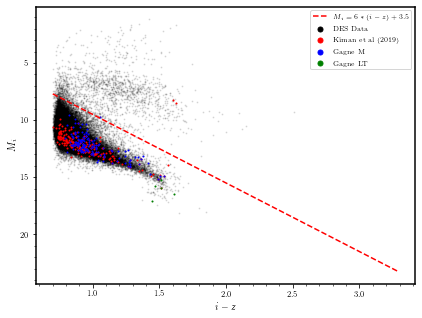

In [ ]:
fig = plt.figure(1, figsize=(2*3.4, 2*3.4*3/4.))
ax2=plt.scatter(des_merged4['i_z'],des_merged4['M_i'],s=1,c='k',label='DES Data')
ax3=plt.scatter(kiman_des_overlap_clean['i_z'],kiman_des_overlap_clean['M_i'],s=1,c='r',label='Kiman et al (2019)')
ax1=plt.scatter(gagne_m_clean['i_z'],gagne_m_clean['M_i'],s=1,c='b',label='Gagne M')
ax4=plt.scatter(gagne_lty_clean['i_z'],gagne_lty_clean['M_i'],s=1,c='g',label='Gagne LT')
plt.plot(x,y,ls='--',color='r',label = '$M_i = {}*(i - z) + {}$'.format(params[0],abs(params[1])))
plt.xlabel('$i - z$')
plt.ylabel('$M_i$')
leg=plt.legend(loc='best',markerscale=5)
for l in leg.get_lines():
    l.set_alpha(1)
#leg.legendHandles[3]._sizes = [20]
ax1.set_alpha(1.0)
ax2.set_alpha(0.1)
ax3.set_alpha(1.0)
ax4.set_alpha(1.0)
plt.minorticks_on()

plt.gca().invert_yaxis()
plt.show()

In [ ]:
sigma_cut = des_merged4[des_merged4['parallax'] > 3*des_merged4['parallax_error']]
print(sigma_cut.shape)

(64146, 240)


In [ ]:
x = np.linspace(sigma_cut['i_z'].min(),sigma_cut['i_z'].max(),len(sigma_cut))
print(len(x))
params = [6,3.5]
y = func(params[0],params[1],x)

64146


In [ ]:
giants_par = sigma_cut[(sigma_cut['M_i'] < func(params[0],params[1],sigma_cut['i_z']))]
dwarfs_par = sigma_cut[(sigma_cut['M_i'] > func(params[0],params[1],sigma_cut['i_z']))]

print(len(giants_par))
print(len(dwarfs_par))

print(len(giants_par)/len(dwarfs_par))

1132
63014
0.017964261910051734


In [ ]:
gagne_m_clean = gagne_m_clean[gagne_m_clean['M_i'] > func(params[0],params[1],gagne_m_clean['i_z'])]
gagne_lty_clean = gagne_lty_clean[gagne_lty_clean['M_i'] > func(params[0],params[1],gagne_lty_clean['i_z'])]
kiman_des_overlap_clean = kiman_des_overlap_clean[kiman_des_overlap_clean['M_i'] > func(params[0],params[1],kiman_des_overlap_clean['i_z'])]
print(gagne_m_clean.shape)
print(gagne_lty_clean.shape)
print(kiman_des_overlap_clean.shape)

(148, 488)
(5, 488)
(228, 500)


In [ ]:
def conf_levels(x,y,bin_n):
  # Make a 2d normed histogram
  H,xedges,yedges=np.histogram2d(x,y,bins=bin_n,normed=True)
  norm=H.sum() # Find the norm of the sum
  # Set contour levels
  contour1=0.99
  contour2=0.95
  contour3=0.68

  # Set target levels as percentage of norm
  target1 = norm*contour1
  target2 = norm*contour2
  target3 = norm*contour3

  # Take histogram bin membership as proportional to Likelihood
  # This is true when data comes from a Markovian process
  def objective(limit, target):
      w = np.where(H>limit)
      count = H[w]
      return count.sum() - target

  # Find levels by summing histogram to objective
  #level1= scipy.optimize.bisect(objective, H.min(), H.max(), args=(target1,))
  level2= scipy.optimize.bisect(objective, H.min(), H.max(), args=(target2,))
  level3= scipy.optimize.bisect(objective, H.min(), H.max(), args=(target3,))

  # Define the levels in an interable:
  levels=[level2,level3]
  return levels

def gauss_levels(x,y):
  x,y = x.values,y.values
  objects = [[a,b] for a,b in zip(x,y)] 
  obj_arr = np.array(objects)

  xmin = x.min()
  xmax = x.max()
  ymin = y.min()
  ymax = y.max()

  X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
  positions = np.vstack([X.ravel(), Y.ravel()])
  #values = np.vstack([m1, m2])
  kernel = stats.gaussian_kde(obj_arr.T)
  Z = np.reshape(kernel(positions).T, X.shape)
  return X,Y,Z

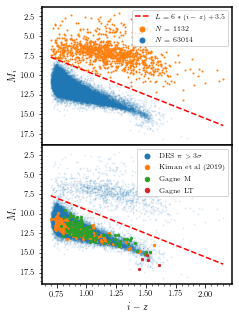

In [ ]:
fig = plt.figure(1, figsize=(1*3.4, 2*3.4*3/4.))
plt.subplots_adjust(hspace=0.0)

axis2 = plt.subplot(2,1,1)
ax1=axis2.scatter(giants_par['i_z'],giants_par['M_i'],s=1,c='C1',label='$N = {}$'.format(len(giants_par)))
ax2=axis2.scatter(dwarfs_par['i_z'],dwarfs_par['M_i'],s=1,c='C0',label='$N = {}$'.format(len(dwarfs_par)),rasterized=True)
axis2.plot(x,y,ls='--',color='r', label = '$L = {}*(i - z) + {}$'.format(params[0],abs(params[1])))
axis2.set_xlabel('$i - z$')
axis2.set_ylabel('$M_i$')
leg=axis2.legend(loc='best',markerscale=5)
for l in leg.get_lines():
    l.set_alpha(1)
ax1.set_alpha(1.0)
ax2.set_alpha(0.1)
axis2.minorticks_on()
axis2.invert_yaxis()

axis1 = plt.subplot(2,1,2)
ax2=axis1.scatter(sigma_cut['i_z'],sigma_cut['M_i'],s=1,c='C0',label='DES $\pi > 3\sigma$',rasterized=True)
ax3=axis1.scatter(kiman_des_overlap_clean['i_z'],kiman_des_overlap_clean['M_i'],s=5,c='C1',label='Kiman et al (2019)')
ax1=axis1.scatter(gagne_m_clean['i_z'],gagne_m_clean['M_i'],s=5,c='C2',label='Gagne M')
ax4=axis1.scatter(gagne_lty_clean['i_z'],gagne_lty_clean['M_i'],s=5,c='C3',label='Gagne LT')
axis1.plot(x,y,ls='--',color='r')
axis1.set_xlabel('$i - z$')
axis1.set_ylabel('$M_i$')
leg=axis1.legend(loc='best',markerscale=5)
for l in leg.get_lines():
    l.set_alpha(1)
leg.legendHandles[3]._sizes = [20]
leg.legendHandles[2]._sizes = [20]
leg.legendHandles[1]._sizes = [20]
ax1.set_alpha(1.0)
ax2.set_alpha(0.1)
ax3.set_alpha(1.0)
ax4.set_alpha(1.0)
axis1.minorticks_on()
axis1.invert_yaxis()

#plt.savefig('gdrive/My Drive/Colab Notebooks/figures/M_i_cut_dwarfs_giants_des.pdf',dpi=300,bbox_inches='tight',padding=0)
plt.show()

In [ ]:
levels_1 = conf_levels(sigma_cut['i_z'],sigma_cut['M_i'],bin_n=25)
levels_2 = conf_levels(kiman_des_overlap_clean['i_z'],kiman_des_overlap_clean['M_i'],bin_n=10)
levels_3 = conf_levels(gagne_m_clean['i_z'],gagne_m_clean['M_i'],bin_n=5)
#levels_4 = conf_levels(gagne_lty_clean['i_z'],gagne_lty_clean['M_i'],bin_n=5)
print(levels_1)
print(levels_2)
print(levels_3)
#print(levels_4)

[0.04948136551758306, 0.6679984344646323]
[0.1709974567300464, 0.7694885552807181]
[0.12264497760852769, 0.4905799104356352]


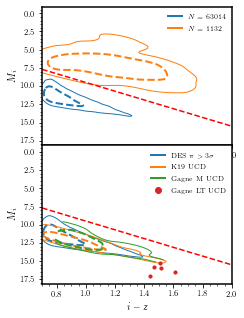

In [ ]:
fig = plt.figure(1, figsize=(1*3.4, 2*3.4*3/4.))

ax = plt.subplot(2,1,1)
plt.subplots_adjust(hspace=0.0)

X1,Y1,Z1 = gauss_levels(dwarfs_par['i_z'],dwarfs_par['M_i'])
X2,Y2,Z2 = gauss_levels(giants_par['i_z'],giants_par['M_i'])
levels_1 = conf_levels(dwarfs_par['i_z'],dwarfs_par['M_i'],bin_n=25)
levels_2 = conf_levels(giants_par['i_z'],giants_par['M_i'],bin_n=5)

ax1 = ax.contour(X1,Y1,Z1, levels=levels_1, colors=['C0'], linestyles=['solid','--','-.'], linewidths=[1,2], zorder=-20)
ax2 = ax.contour(X2,Y2,Z2, levels=levels_2, colors=['C1'], linestyles=['solid','--','-.'], linewidths=[1,2], zorder=-20)
ax.plot(x,y,ls='--',color='r', 
        #label = '$L = {}*(i - z) + {}$'.format(params[0],abs(params[1]))
        )
ax.set_xlabel('$i - z$')
ax.set_ylabel('$M_i$')
ax.set_xlim(0.70,2.0)
ax.invert_yaxis()
plt.minorticks_on()

X1,Y1,Z1 = gauss_levels(sigma_cut['i_z'],sigma_cut['M_i'])
X2,Y2,Z2 = gauss_levels(kiman_des_overlap_clean['i_z'],kiman_des_overlap_clean['M_i'])
X3,Y3,Z3 = gauss_levels(gagne_m_clean['i_z'],gagne_m_clean['M_i'])
#X4,Y4,Z4 = gauss_levels(des_pred_kiman['IMAG_DERED']-des_pred_kiman['ZMAG_DERED'],des_pred_kiman['ZMAG_DERED'] - des_pred_kiman['YMAG_DERED'])
levels_1 = conf_levels(sigma_cut['i_z'],sigma_cut['M_i'],bin_n=20)
levels_2 = conf_levels(kiman_des_overlap_clean['i_z'],kiman_des_overlap_clean['M_i'],bin_n=5)
levels_3 = conf_levels(gagne_m_clean['i_z'],gagne_m_clean['M_i'],bin_n=5)

ax_2 = plt.subplot(2,1,2)
ax1 = ax_2.contour(X1,Y1,Z1, levels=levels_1, colors=['C0'], linestyles=['solid','--','-.'], linewidths=[1,2], zorder=-20)
ax2 = ax_2.contour(X2,Y2,Z2, levels=levels_2, colors=['C1'], linestyles=['solid','--','-.'], linewidths=[1,2], zorder=-20)
ax3 = ax_2.contour(X3,Y3,Z3, levels=levels_3, colors=['C2'], linestyles=['solid','--','-.'], linewidths=[1,2], zorder=-20)
ax4= ax_2.scatter(gagne_lty_clean['i_z'],gagne_lty_clean['M_i'],s=10,c='C3')
ax_2.plot(x,y,ls='--',color='r')
ax_2.set_xlabel('$i - z$')
ax_2.set_ylabel('$M_i$')

ax.plot([0,0],[0,0], ls='solid', c='C0', lw=2, label=r'$N = {}$'.format(len(dwarfs_par)))
ax.plot([0,0],[0,0], ls='solid', c='C1', lw=2, label=r'$N = {}$'.format(len(giants_par)))
ax.legend(loc='upper right', frameon=False)

ax_2.plot([0,0],[0,0], ls='solid', c='C0', lw=2, label=r'DES $\pi > 3\sigma$')
ax_2.plot([0,0],[0,0], ls='solid', c='C1', lw=2, label=r'K19 UCD')
ax_2.plot([0,0],[0,0], ls='solid', c='C2', lw=2, label=r'Gagne M UCD')
ax_2.plot([0,0],[0,0], 'o', c='C3', label=r'Gagne LT UCD')
ax_2.legend(loc='upper right', frameon=False)

plt.minorticks_on()
ax_2.set_xlim(0.70,2.0)
ax_2.invert_yaxis()
#ax_2.set_ylim(0.0,1.0)
#plt.tight_layout()
plt.savefig('gdrive/My Drive/Colab Notebooks/figures/M_i_cut_dwarfs_giants_des_contour.pdf',dpi=300,bbox_inches='tight',padding=0)
plt.show()

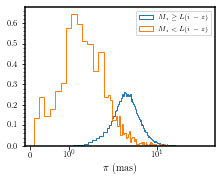

In [ ]:
fig = plt.figure(1, figsize=(1*3.4, 1*3.4*3/4.))
plt.hist(dwarfs_par['parallax'],bins=500,histtype='step',density=True,label='$M_i \geq L(i-z)$')
plt.hist(giants_par['parallax'],bins=100,histtype='step',density=True,label='$M_i < L(i-z)$')
#plt.hist(des_c4_g['log_par'],bins=1000,histtype='step',density=True)
plt.xlabel('$\pi$ (mas)') 
plt.xscale('symlog')
plt.legend(loc='upper right')
plt.minorticks_on()
plt.savefig('gdrive/My Drive/Colab Notebooks/figures/des_par_distributions.pdf',dpi=300,bbox_inches='tight',padding=0)
plt.show()

# Kiman et al. (2019) cuts and 1kpc cuts for Giants

To ensure we select dwarfs for our training set, we follow the cuts made by Kiman et al 2019:

1. `parallax_over_error` > 10
2. `visibility_periods_used` > 8
3. `UWE` < 1.2 $\times$ max(1.4, $\exp(-0.2(G -  19.5))$)

`parallax_over_error` = `parallax`/`parallax_error`

In [ ]:
def uwe_squared(chi2,obs):
    return chi2/(obs - 5)
    
def uwe_cut(gmag):
    return 1.2*max(1.4,np.exp(-0.2*(float(gmag) - 19.5)))

In [ ]:
dwarfs_par['UWE'] = np.sqrt(uwe_squared(dwarfs_par['astrometric_chi2_al'],
                                         dwarfs_par['astrometric_n_obs_al']))

filtered = dwarfs_par[['COADD_OBJECT_ID','UWE','phot_g_mean_mag']]

# UWE cut:
s = [[col[0],col[1]] for index, col in filtered.T.iteritems() if col[1] < uwe_cut(col[2])]

s_df = pd.DataFrame(s,columns=['COADD_OBJECT_ID','UWE'])
s_df.shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


(62056, 2)

In [ ]:
def merger(df1,df2,r_col,l_col,method):
  df3 = df1.merge(df2,left_on=l_col,right_on=r_col,how=method,suffixes=('','_y'))
  df3 = df3.drop(df3.filter(regex='_y').columns, axis=1)
  df3 = df3.drop_duplicates(subset=l_col)
  return df3

In [ ]:
des_tset_dwarfs = merger(s_df,dwarfs_par,l_col='COADD_OBJECT_ID',r_col='COADD_OBJECT_ID',method='inner')
des_tset_dwarfs.shape

(62056, 241)

In [ ]:
print('Total dwarfs and giants:',len(des_tset_dwarfs) + len(giants_par))

Total dwarfs and giants: 63188


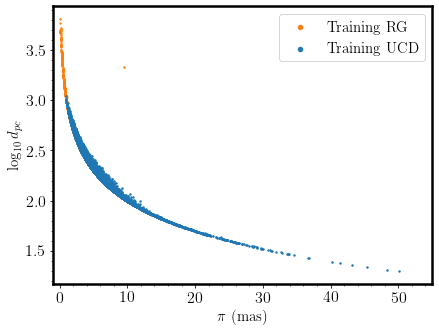

In [ ]:
plt.figure(figsize=(2*3.4,2*3.4*3/4.))
ax2=plt.scatter(giants_par['parallax'],np.log10(giants_par['rest']),
            s=2,c='C1',label='Training RG')
ax1=plt.scatter(des_tset_dwarfs['parallax'],np.log10(des_tset_dwarfs['rest']),
            s=2,c='C0',label='Training UCD',rasterized=True)
plt.xlabel('$\pi$ (mas)')
plt.ylabel('$\log_{10}{d_{pc}}$')
leg=plt.legend(loc='best',markerscale=5)
leg.legendHandles[1]._sizes = [20]
leg.legendHandles[0]._sizes = [20]
for l in leg.get_lines():
    l.set_alpha(1)
ax1.set_alpha(1.0)
ax2.set_alpha(1.0)
plt.xlim(-1.0,55)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.minorticks_on()

plt.savefig('gdrive/My Drive/Colab Notebooks/figures/des_par_v_dist.pdf',dpi=300,bbox_inches='tight',padding=0)
plt.show()

# Pre-Training Set Assembly

Pre-Training set contains only point sources from DES, and the objects from Gagne and Kiman

In [ ]:
#giants_1kpc['label'] = 'hm*'
giants_par['label'] = 'hm*'
des_tset_dwarfs['label'] = 'lm*'
gagne_m_clean['label'] = 'lm*'
gagne_lty_clean['label'] = 'lm*'
kiman_des_overlap_clean['label'] = 'lm*'

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
# placing trackers to see what surveys the data comes from:
# rob: Taking away the 1kpc to see the new color - absolute magnitude profiles
giants_par['survey_marker'] = 'des_gaia_parallax'
des_tset_dwarfs['survey_marker'] = 'des_gaia_parallax'
gagne_m_clean['survey_marker'] = 'gagne_m'
gagne_lty_clean['survey_marker'] = 'gagne_lty'
kiman_des_overlap_clean['survey_marker'] = 'kiman'

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
relevant_column_list = ['COADD_OBJECT_ID','RA','DEC','IMAG_DERED','ZMAG_DERED','YMAG_DERED','IMAG','ZMAG','YMAG', # new corrected magnitudes
 'MAG_AUTO_I',
 'MAG_AUTO_Y',
 'MAG_AUTO_Z',
 'MAG_AUTO_I_DERED',
 'MAG_AUTO_Y_DERED',
 'MAG_AUTO_Z_DERED',
 'WAVG_MAG_PSF_I',
 'WAVG_MAG_PSF_Y',
 'WAVG_MAG_PSF_Z',
 'WAVG_MAG_PSF_I_DERED',
 'WAVG_MAG_PSF_Y_DERED',
 'WAVG_MAG_PSF_Z_DERED',
'parallax',
'parallax_error',
'parallax_over_error',
'pmra',
'pmra_error',
'pmdec',
'pmdec_error',
'ra_dec_corr',
'ra_parallax_corr',
'ra_pmra_corr',
'ra_pmdec_corr',
'dec_parallax_corr',
'dec_pmra_corr',
'dec_pmdec_corr',
'parallax_pmra_corr',
'parallax_pmdec_corr',
'pmra_pmdec_corr',
'radius_val',
'radius_percentile_lower',
'radius_percentile_upper',
'lum_val',
'lum_percentile_lower',
'lum_percentile_upper',
'astrometric_gof_al',
'astrometric_chi2_al',
'astrometric_excess_noise',
'astrometric_excess_noise_sig',
'astrometric_weight_al',
'astrometric_pseudo_colour',
'astrometric_pseudo_colour_error',
'mean_varpi_factor_al',
'astrometric_sigma5d_max',
'phot_g_mean_flux',
'phot_g_mean_flux_error',
'phot_g_mean_flux_over_error',
'phot_g_mean_mag',
'phot_bp_mean_flux',
'phot_bp_mean_flux_error',
'phot_bp_mean_flux_over_error',
'phot_bp_mean_mag',
'phot_rp_mean_flux',
'phot_rp_mean_flux_error',
'phot_rp_mean_flux_over_error',
'phot_rp_mean_mag',
'phot_bp_rp_excess_factor',
'bp_rp',
'bp_g',
'g_rp',
'radial_velocity',
'radial_velocity_error',
'l',
'b',
'ecl_lon',
'ecl_lat',
'teff_val',
'teff_percentile_lower',
'teff_percentile_upper',
'ref_epoch',
'rv_template_teff',
'rv_template_logg',
'rv_template_fe_h',
'a_g_val',
'a_g_percentile_lower',
'a_g_percentile_upper',
'e_bp_min_rp_val',
'e_bp_min_rp_percentile_lower',
'e_bp_min_rp_percentile_upper',
'random_id',
'random_index',
'priam_flags',
'flame_flags',
'htm9',
'ring256',
'nest4096',
'astrometric_n_obs_al',
'astrometric_n_obs_ac',
'astrometric_n_good_obs_al',
'astrometric_n_bad_obs_al',
'astrometric_params_solved',
'astrometric_primary_flag',
'astrometric_matched_observations',
'visibility_periods_used',
'frame_rotator_object_type',
'matched_observations',
'duplicated_source',
'phot_g_n_obs',
'phot_bp_n_obs',
'phot_rp_n_obs',
'phot_proc_mode',
'rv_nb_transits',
'phot_variable_flag',
'designation',
'dist_arcsec',
'best_use_cntr',
'cc_flags',
'dec_pm',
'elat',
'elon',
'ext_flg',
'glat',
'glon',
'ph_qual',
'ra_pm',
'var_flg',
'w1m',
'w1mpro',
'w1nm',
'w1rchi2',
'w1rchi2_pm',
'w1sigmpro',
'w1snr',
'w2m',
'w2mpro',
'w2nm',
'w2rchi2',
'w2rchi2_pm',
'w2sigmpro',
'w2snr','survey_marker','label']

In [ ]:
des_tset_psources1 = pd.concat([gagne_m_clean[relevant_column_list],gagne_lty_clean[relevant_column_list],
                                kiman_des_overlap_clean[relevant_column_list]])
print(des_tset_psources1.shape)
print(Counter(des_tset_psources1['survey_marker']))

des_tset_psources1_nodupes = des_tset_psources1.drop_duplicates(subset='COADD_OBJECT_ID',keep='last')
print(Counter(des_tset_psources1_nodupes['survey_marker']))
print(des_tset_psources1_nodupes.shape) # 34 overlaps between kiman and gagne m, and 1 overlap between kiman and gagne_lty1

(381, 141)
Counter({'kiman': 228, 'gagne_m': 148, 'gagne_lty': 5})
Counter({'kiman': 222, 'gagne_m': 97, 'gagne_lty': 4})
(323, 141)


In [ ]:
des_tset_psources2 = pd.concat([des_tset_dwarfs[relevant_column_list],giants_par[relevant_column_list]])
des_tset_psources2_nodupes = des_tset_psources2.drop_duplicates(subset='COADD_OBJECT_ID',keep='last')
print(des_tset_psources2.shape)
print(des_tset_psources2_nodupes.shape)
print(Counter(des_tset_psources2_nodupes['survey_marker']))

(63188, 141)
(63188, 141)
Counter({'des_gaia_parallax': 63188})


In [ ]:
merged = des_tset_psources2_nodupes.merge(des_tset_psources1_nodupes,on='COADD_OBJECT_ID',how='outer',indicator=True,suffixes=('','_y'))
print(Counter(merged['_merge']))

Counter({'left_only': 62879, 'both': 309, 'right_only': 14})


In [ ]:
gaia_par_objs = merged[merged['_merge'] =='left_only']
gaia_par_objs = gaia_par_objs.drop(gaia_par_objs.filter(regex='_y').columns, axis=1)
print(gaia_par_objs.shape)

(62879, 142)


In [ ]:
des_tset_psources = pd.concat([gaia_par_objs,des_tset_psources1_nodupes])
des_tset_psources.shape

(63202, 142)

In [ ]:
Counter(des_tset_psources.survey_marker)

Counter({'des_gaia_parallax': 62879,
         'gagne_lty': 4,
         'gagne_m': 97,
         'kiman': 222})

In [ ]:
Counter(des_tset_psources.label)

Counter({'hm*': 1132, 'lm*': 62070})

In [ ]:
des_tset_psources_nodupes = des_tset_psources.drop_duplicates(subset='COADD_OBJECT_ID',keep='last')
print(Counter(des_tset_psources_nodupes['survey_marker']))
print(des_tset_psources_nodupes.shape)

Counter({'des_gaia_parallax': 62879, 'kiman': 222, 'gagne_m': 97, 'gagne_lty': 4})
(63202, 142)


In [ ]:
des_tset_psources_nodupes.to_csv(path_des+'des_dered_data/des_tset_psources_allgiants.csv',index=False)

# Galaxy and QSO Prep

Adding Galaxies from the Hyper Suprime-Cam Subaru Program DR 2 and QSO's from the MILLIQUAS catalog.

In [ ]:
des_tset_psources_nodupes = pd.read_csv(path_des+'des_dered_data/des_tset_psources_allgiants.csv')

In [ ]:
hsc_dr2 = pd.read_csv(path_des+'hsc_pdr2_ctheissen.csv')
hsc_dr2.shape

(15617323, 10)

In [ ]:
# matched to des_c2_dered:
des_hscdr2 = pd.read_csv(path_des+'des_dered_data/des_c2_dered_hsc.csv')
des_hscdr2.shape

(10881, 6)

In [ ]:
des_milliquas = pd.read_csv(path_des+'des_dered_data/des_c2_dered_milliquas.csv')
des_milliquas.shape

(61, 6)

In [ ]:
des_hscdr2_clean = des_hscdr2.merge(des_merged3,on='COADD_OBJECT_ID',how='inner',suffixes=('','_dup'))
des_hscdr2_clean = des_hscdr2_clean.drop(des_hscdr2_clean.filter(regex='_dup').columns, axis=1)
des_hscdr2_clean.shape

(195, 233)

In [ ]:
des_milliquas_clean = des_milliquas.merge(des_merged3,on='COADD_OBJECT_ID',how='inner',suffixes=('','_dup'))
des_milliquas_clean = des_milliquas_clean.drop(des_milliquas_clean.filter(regex='_dup').columns, axis=1)
des_milliquas_clean.shape

(10, 231)

In [ ]:
des_hscdr2_clean['label'] = 'gal'
des_milliquas_clean['label'] = 'qso'
des_hscdr2_clean['survey_marker'] = 'hsc_dr2'
des_milliquas_clean['survey_marker'] = 'milliquas'

# Final Training Set

In [ ]:
des_tset = pd.concat([des_tset_psources_nodupes,des_hscdr2_clean[relevant_column_list],des_milliquas_clean[relevant_column_list]])
des_tset.shape

(63407, 142)

In [ ]:
des_tset.to_csv(path_des+'des_dered_data/des_tset_rob_cuts_dered_allgiants.csv',index=False)

In [ ]:
Counter(des_tset['label'])

Counter({'gal': 195, 'hm*': 1132, 'lm*': 62070, 'qso': 10})

In [ ]:
des_tset = pd.read_csv(path_des+'des_dered_data/des_tset_rob_cuts_dered_allgiants.csv')

In [ ]:
lm = des_tset[des_tset['label'] == 'lm*']
hm = des_tset[des_tset['label'] == 'hm*']
gal = des_tset[des_tset['label'] == 'gal']
qso = des_tset[des_tset['label'] == 'qso']

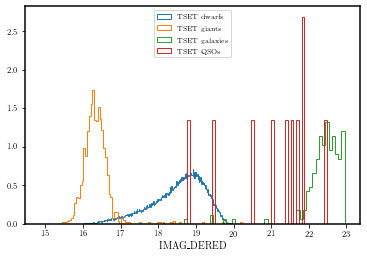

In [ ]:
plt.hist(lm['IMAG_DERED'],bins=500,histtype='step',density=True,label='TSET dwarfs')
plt.hist(hm['IMAG_DERED'],bins=100,histtype='step',density=True,label='TSET giants')
plt.hist(gal['IMAG_DERED'],bins=50,histtype='step',density=True,label='TSET galaxies')
plt.hist(qso['IMAG_DERED'],bins=50,histtype='step',density=True,label='TSET QSOs')
plt.xlabel('IMAG\_DERED')
plt.legend(loc='upper center')
plt.show()

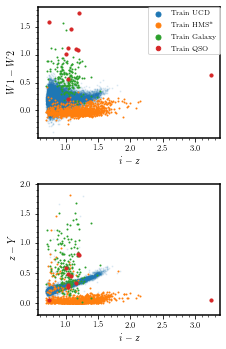

In [ ]:
fig = plt.figure(1, figsize=(1*3.4, 2*3.4*3/4.))

ax = plt.subplot(2,1,1)
ax1 = ax.scatter(lm['IMAG_DERED']-lm['ZMAG_DERED'],lm['w1mpro'] - lm['w2mpro'],
                c='C0',s=1,label='Train UCD',rasterized=True)
ax4 = ax.scatter(hm['IMAG_DERED']-hm['ZMAG_DERED'],hm['w1mpro'] - hm['w2mpro'],
                  c='C1',s=1,label='Train HMS*')
ax2 = ax.scatter(gal['IMAG_DERED']-gal['ZMAG_DERED'],gal['w1mpro'] - gal['w2mpro'],
                c='C2',s=1,label='Train Galaxy')
ax3 = ax.scatter(qso['IMAG_DERED']-qso['ZMAG_DERED'],qso['w1mpro'] - qso['w2mpro'],
                  c='C3',s=10,label='Train QSO')
plt.ylabel('$W1 - W2$')
plt.xlabel('$i - z$')
#plt.xlim(0,5)
#plt.ylim(-0.5,2.0)
leg=plt.legend(loc='upper right',markerscale=5, borderaxespad=0.)
leg.legendHandles[3]._sizes = [20]
for l in leg.get_lines():
    l.set_alpha(1)
ax1.set_alpha(0.1)
ax2.set_alpha(1.0)
ax3.set_alpha(1.0)
ax4.set_alpha(1.0)
#ax5.set_alpha(0.3)
plt.minorticks_on()


ax_2 = plt.subplot(2,1,2)
ax1=ax_2.scatter(lm['IMAG_DERED'] - lm['ZMAG_DERED'],lm['ZMAG_DERED'] - lm['YMAG_DERED'],
                c='C0',s=1,label='Train UCD',rasterized=True)
ax4 = ax_2.scatter(hm['IMAG_DERED'] - hm['ZMAG_DERED'],hm['ZMAG_DERED'] - hm['YMAG_DERED'],
                  c='C1',s=1,label='Train HMS*')
ax2=ax_2.scatter(gal['IMAG_DERED'] - gal['ZMAG_DERED'],gal['ZMAG_DERED'] - gal['YMAG_DERED'],
                c='C2',s=1,label='Train GAL')
ax3 = ax_2.scatter(qso['IMAG_DERED'] - qso['ZMAG_DERED'],qso['ZMAG_DERED'] - qso['YMAG_DERED'],
                  c='C3',s=10,label='Train QSO')
plt.xlabel('$i - z$')
plt.ylabel('$z - Y$')
plt.ylim(-0.2,2.0)
#leg=plt.legend(loc='upper right',markerscale=10, borderaxespad=0.)
#for l in leg.get_lines():
    #l.set_alpha(1)
ax1.set_alpha(0.1)
ax2.set_alpha(1.0)
ax3.set_alpha(1.0)
ax4.set_alpha(1.0)

plt.minorticks_on()
plt.tight_layout()
plt.savefig('gdrive/My Drive/Colab Notebooks/figures/des_training_parameter_space_scatter.pdf',dpi=300,bbox_inches='tight',padding=0)
plt.show()

In [ ]:
levels_1 = conf_levels(lm['IMAG_DERED']-lm['ZMAG_DERED'],lm['w1mpro'] - lm['w2mpro'],bin_n = 10)
levels_2 = conf_levels(hm['IMAG_DERED']-hm['ZMAG_DERED'],hm['w1mpro'] - hm['w2mpro'],bin_n = 10)
levels_3 = conf_levels(gal['IMAG_DERED']-gal['ZMAG_DERED'],gal['w1mpro'] - gal['w2mpro'],bin_n = 7)

print(levels_1)
print(levels_2)
print(levels_3)
#print(levels_4)

[0.6630172622649336, 5.8127845070360324]
[0.4561917657314513, 4.105725891592439]
[0.41435187415759317, 1.657407496634471]


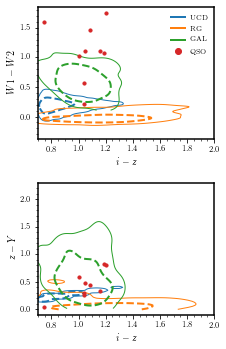

In [ ]:
fig = plt.figure(1, figsize=(1*3.4, 2*3.4*3/4.))

ax = plt.subplot(2,1,1)

X1,Y1,Z1 = gauss_levels(lm['IMAG_DERED']-lm['ZMAG_DERED'],lm['w1mpro'] - lm['w2mpro'])
X2,Y2,Z2 = gauss_levels(hm['IMAG_DERED']-hm['ZMAG_DERED'],hm['w1mpro'] - hm['w2mpro'])
X3,Y3,Z3 = gauss_levels(gal['IMAG_DERED']-gal['ZMAG_DERED'],gal['w1mpro'] - gal['w2mpro'])
#X4,Y4,Z4 = gauss_levels(qso['IMAG_DERED'] - qso['ZMAG_DERED'],qso['w1mpro'] - qso['w2mpro'])
levels_1 = conf_levels(lm['IMAG_DERED']-lm['ZMAG_DERED'],lm['w1mpro'] - lm['w2mpro'],bin_n = 25)
levels_2 = conf_levels(hm['IMAG_DERED']-hm['ZMAG_DERED'],hm['w1mpro'] - hm['w2mpro'],bin_n = 10)
levels_3 = conf_levels(gal['IMAG_DERED']-gal['ZMAG_DERED'],gal['w1mpro'] - gal['w2mpro'],bin_n = 7)
#levels_4 = conf_levels(qso['IMAG_DERED'] - qso['ZMAG_DERED'],qso['w1mpro'] - qso['w2mpro'],bin_n = 3)

ax1 = ax.contour(X1,Y1,Z1, levels=levels_1, colors=['C0'], linestyles=['solid','--','-.'], linewidths=[1,2], zorder=-20)
ax2 = ax.contour(X2,Y2,Z2, levels=levels_2, colors=['C1'], linestyles=['solid','--','-.'], linewidths=[1,2], zorder=-20)
ax3 = ax.contour(X3,Y3,Z3, levels=levels_3, colors=['C2'], linestyles=['solid','--','-.'], linewidths=[1,2], zorder=-20)
ax4 = ax.scatter(qso['IMAG_DERED']-qso['ZMAG_DERED'],qso['w1mpro'] - qso['w2mpro'],
                  c='C3',s=10)
plt.ylabel('$W1 - W2$')
plt.xlabel('$i - z$')
ax.set_xlim(0.70,2.0)
#ax.set_ylim(0.0,2.0)
plt.minorticks_on()

X1,Y1,Z1 = gauss_levels(lm['IMAG_DERED']-lm['ZMAG_DERED'],lm['ZMAG_DERED'] - lm['YMAG_DERED'])
X2,Y2,Z2 = gauss_levels(hm['IMAG_DERED']-hm['ZMAG_DERED'],hm['ZMAG_DERED'] - hm['YMAG_DERED'])
X3,Y3,Z3 = gauss_levels(gal['IMAG_DERED']-gal['ZMAG_DERED'],gal['ZMAG_DERED'] - gal['YMAG_DERED'])
#X4,Y4,Z4 = gauss_levels(qso['IMAG_DERED'] - qso['ZMAG_DERED'],qso['ZMAG_DERED'] - qso['YMAG_DERED'])
levels_1 = conf_levels(lm['IMAG_DERED']-lm['ZMAG_DERED'],lm['ZMAG_DERED'] - lm['YMAG_DERED'],bin_n = 25)
levels_2 = conf_levels(hm['IMAG_DERED']-hm['ZMAG_DERED'],hm['ZMAG_DERED'] - hm['YMAG_DERED'],bin_n = 10)
levels_3 = conf_levels(gal['IMAG_DERED']-gal['ZMAG_DERED'],gal['ZMAG_DERED'] - gal['YMAG_DERED'],bin_n = 5)
#levels_4 = conf_levels(qso['IMAG_DERED'] - qso['ZMAG_DERED'],qso['ZMAG_DERED'] - qso['YMAG_DERED'],bin_n = 3)

ax_2 = plt.subplot(2,1,2)
ax1 = ax_2.contour(X1,Y1,Z1, levels=levels_1, colors=['C0'], linestyles=['solid','--','-.'], linewidths=[1,2], zorder=-20)
ax2 = ax_2.contour(X2,Y2,Z2, levels=levels_2, colors=['C1'], linestyles=['solid','--','-.'], linewidths=[1,2], zorder=-20)
ax3 = ax_2.contour(X3,Y3,Z3, levels=levels_3, colors=['C2'], linestyles=['solid','--','-.'], linewidths=[1,2], zorder=-20)
ax4 = ax_2.scatter(qso['IMAG_DERED']-qso['ZMAG_DERED'],qso['ZMAG_DERED'] - qso['YMAG_DERED'],
                  c='C3',s=10)
ax_2.set_xlim(0.70,2.0)
ax_2.set_ylim(-0.1,2.3)
plt.xlabel('$i - z$')
plt.ylabel('$z - Y$')

ax.plot([0,0],[0,0], ls='solid', c='C0', lw=2, label=r'UCD')
ax.plot([0,0],[0,0], ls='solid', c='C1', lw=2, label=r'RG')
ax.plot([0,0],[0,0], ls='solid', c='C2', lw=2, label=r'GAL')
ax.plot([0,0],[0,0], 'o', c='C3', label=r'QSO')
ax.legend(loc='upper right', frameon=False)

plt.minorticks_on()
plt.tight_layout()
plt.savefig('gdrive/My Drive/Colab Notebooks/figures/des_training_parameter_space_contour.pdf',dpi=300,bbox_inches='tight',padding=0)
plt.show()